In [10]:
import yfinance as yf
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random




In [11]:
stocks = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', 'BABA', 'NOW', 'ADBE',
    'CRM', 'V', 'KO', 'PFE', 'PEP', 'INTC', 'CSCO', 'IBM', 'NFLX', 'ORCL'
]

# historical data for this time period
start_period = '2018-01-01'
end_period = '2022-12-31'

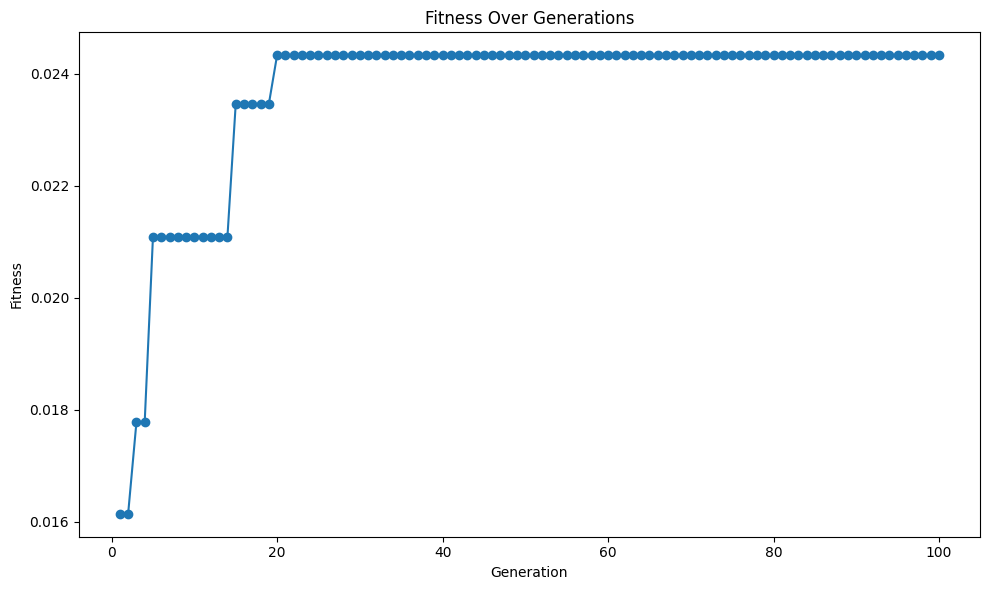

Simple EP: Optimized Expected Return: 0.0243


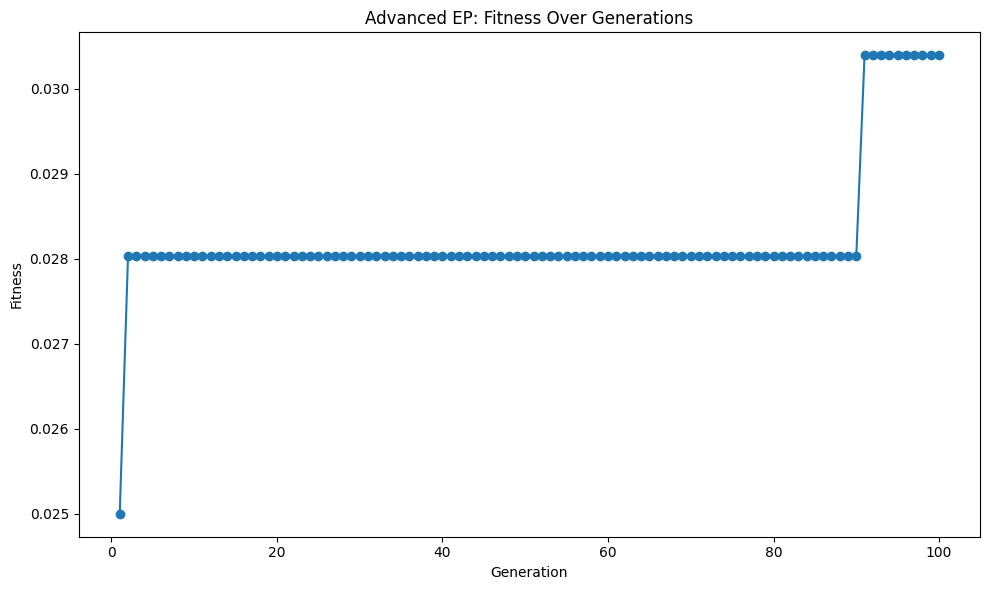

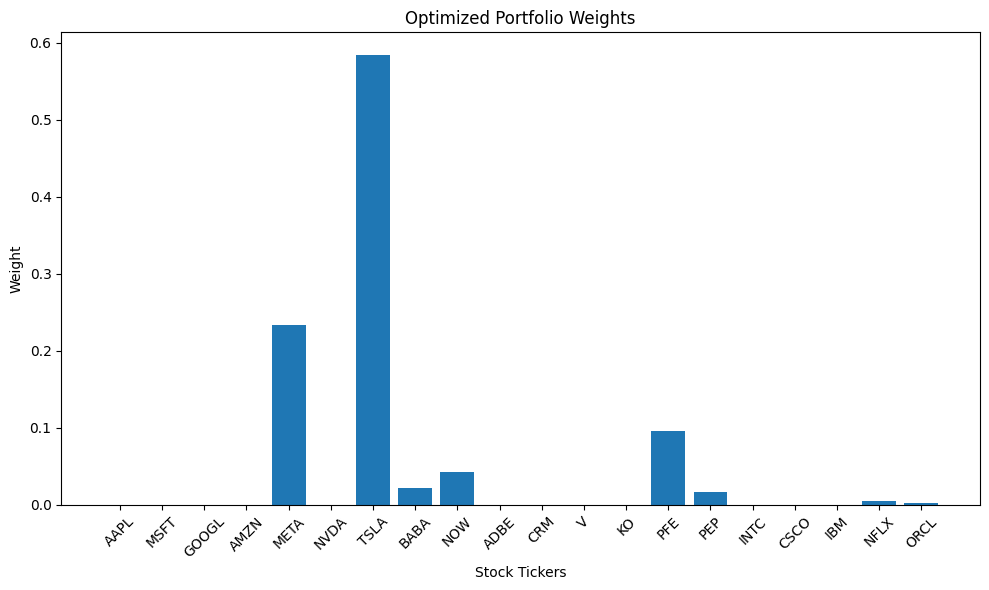

Advanced EP: Optimized Expected Return: 0.0304


In [12]:

# making a folder that is meant to keep stock datasets incase there isnt one already made.
def create_folder():
    if not os.path.exists('Stocks'):
        os.makedirs('Stocks')

# the function meant for downloading and storing each dataset of the 20 stocks
def download_stock_dataset(stock):
    try:
        data = yf.download(stock, start=start_period, end=end_period, progress=False)
        data.to_csv(f'Stocks/{stock}.csv')
    except Exception as e:
        print(f'logging for errors for the stock {stock}: {e}')

# function to calculate monthly returns from daily stock prices
def calculate_monthly_returns(stock):
    try:
        # Load the stock data from CSV
        data = pd.read_csv(f'Stocks/{stock}.csv', parse_dates=['Date'], index_col='Date')
        # Calculate monthly returns
        monthly_returns = data['Adj Close'].resample('ME').ffill().pct_change()
        # Save the monthly returns to a new CSV file
        monthly_returns.to_csv(f'Stocks/{stock}_monthly_returns.csv', header=['Monthly Return'])
        return monthly_returns
    except Exception as e:
        print(f'Error calculating monthly returns for {stock}: {e}')
        return None

# function to calculate the covariance matrix of monthly returns for all stocks
def calculate_covariance_matrix():
    try:
        monthly_returns_data = pd.DataFrame()
        for stock in stocks:
            # Load the monthly returns for each stock
            data = pd.read_csv(f'Stocks/{stock}_monthly_returns.csv', parse_dates=['Date'], index_col='Date')
            monthly_returns_data[stock] = data['Monthly Return']
        
        # calculate covariance matrix
        covariance_matrix = monthly_returns_data.cov()
        # save the covariance matrix to a CSV file
        covariance_matrix.to_csv('Stocks/covariance_matrix.csv')
        print('Covariance matrix has been calculated and saved.')

        # plotting the covariance matrix
        plt.figure(figsize=(15, 10))
        plt.imshow(covariance_matrix, cmap='coolwarm', interpolation='none')
        plt.colorbar()
        plt.xticks(range(len(stocks)), stocks, rotation=90)
        plt.yticks(range(len(stocks)), stocks)
        plt.title('Covariance Matrix of Monthly Returns')
        plt.tight_layout()
        plt.savefig('Stocks/covariance_matrix_plot.png')
        plt.show()
    except Exception as e:
        print(f'Error calculating covariance matrix: {e}')

# function to plot monthly returns for each stock
def plot_monthly_returns():
    try:
        plt.figure(figsize=(15, 10))
        for stock in stocks:
            # loading the monthly returns for each stock
            data = pd.read_csv(f'Stocks/{stock}_monthly_returns.csv', parse_dates=['Date'], index_col='Date')
            plt.plot(data.index, data['Monthly Return'], label=stock)
        
        plt.axhline(0, color='black', linewidth=1, linestyle='-')
        plt.xlabel('Date')
        plt.ylabel('Monthly Return')
        plt.title('Monthly Returns of Stocks')
        plt.legend()
        plt.tight_layout()
        plt.savefig('Stocks/monthly_returns_plot.png')
        plt.show()
    except Exception as e:
        print(f'Error plotting monthly returns: {e}')


def load_monthly_returns():
    monthly_returns_data = pd.DataFrame()
    for stock in stocks:
        data = pd.read_csv(f'Stocks/{stock}_monthly_returns.csv', parse_dates=['Date'], index_col='Date')
        monthly_returns_data[stock] = data['Monthly Return']
    return monthly_returns_data

# fitness function to calculate expected return for a portfolio
def calculate_fitness(weights, returns_data):
    portfolio_return = np.dot(weights, returns_data.mean())
    return portfolio_return

# mutating a solution by adding random noise to the weights (foer simple EP)
def mutate(weights, mutation_rate=0.1):
    new_weights = weights + np.random.normal(0, mutation_rate, len(weights))
    new_weights = np.clip(new_weights, 0, None)
    new_weights = new_weights / new_weights.sum()  # Ensure weights sum to 1
    return new_weights

# basic Evolutionary Programming to optimize portfolio weights
def basic_evolutionary_programming(returns_data, n_generations=100, population_size=20, mutation_rate=0.1):
    # initialize population with random weights
    population = [np.random.dirichlet(np.ones(len(stocks))) for _ in range(population_size)]
    best_solution = None
    best_fitness = -np.inf
    fitness_over_time = []
    
    for generation in range(n_generations):
        new_population = []
        for individual in population:
            # mutate individual to create a new candidate
            new_individual = mutate(individual, mutation_rate)
            new_population.append(new_individual)
        
        # evaluating fitness of the new population
        population = new_population
        for individual in population:
            fitness = calculate_fitness(individual, returns_data)
            if fitness > best_fitness:
                best_fitness = fitness
                best_solution = individual
        
        # storing the best fitness for plotting later
        fitness_over_time.append(best_fitness)
    
    # plotting fitness over generations
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_generations + 1), fitness_over_time, marker='o')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title('Fitness Over Generations')
    plt.tight_layout()
    plt.show()
    
    return best_solution, best_fitness

# plotting the optimized portfolio weights
def plot_optimized_weights(weights):
    plt.figure(figsize=(10, 6))
    plt.bar(stocks, weights)
    plt.xlabel('Stock Tickers')
    plt.ylabel('Weight')
    plt.title('Optimized Portfolio Weights')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# mutating for advanced EP
def mutate_advanced(weights, mutation_rate=0.1, mutation_adaptive_factor=0.05):
    adaptive_mutation = mutation_rate + np.abs(np.random.normal(0, mutation_adaptive_factor, len(weights)))  # Ensure adaptive_mutation is non-negative
    new_weights = weights + np.random.normal(0, adaptive_mutation, len(weights))
    new_weights = np.clip(new_weights, 0, None)
    new_weights = new_weights / new_weights.sum()  # Ensure weights sum to 1
    return new_weights

# tournament selection function for selecting individuals from the population
def tournament_selection(population, fitnesses, tournament_size=3):
    selected = []
    for _ in range(len(population)):
        participants = np.random.choice(len(population), tournament_size, replace=False)
        best_participant = max(participants, key=lambda idx: fitnesses[idx])
        selected.append(population[best_participant])
    return selected

# Aavanced Evolutionary Programming to optimize portfolio weights
def advanced_evolutionary_programming(returns_data, n_generations=100, population_size=20, mutation_rate=0.1):
    # initialize population with random weights
    population = [np.random.dirichlet(np.ones(len(stocks))) for _ in range(population_size)]
    best_solution = None
    best_fitness = -np.inf
    fitness_over_time = []
    
    for generation in range(n_generations):
        # evaluate fitness of the current population
        fitnesses = [calculate_fitness(individual, returns_data) for individual in population]
        
        # selection individuals for the next generation using tournament selection
        selected_population = tournament_selection(population, fitnesses)
        
        # creating new population through mutation
        new_population = [mutate_advanced(individual, mutation_rate) for individual in selected_population]
        
        # evaluate fitness of the new population
        population = new_population
        for individual in population:
            fitness = calculate_fitness(individual, returns_data)
            if fitness > best_fitness:
                best_fitness = fitness
                best_solution = individual
        
        # storing the best fitness for plotting later
        fitness_over_time.append(best_fitness)
    
    # plot fitness over generations
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_generations + 1), fitness_over_time, marker='o')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title('Advanced EP: Fitness Over Generations')
    plt.tight_layout()
    plt.show()
    
    return best_solution, best_fitness



def main():
    create_folder()
    # downloading stock datasets and storing them as CSV
    for stock in stocks:
        download_stock_dataset(stock)

    # calculating monthly returns for each stock
    for stock in stocks:
        calculate_monthly_returns(stock)

    #plot_monthly_returns()
    #calculate_covariance_matrix()

    # loading of  monthly returns data
    returns_data = load_monthly_returns()
    
    # running basic evolutionary programming
    optimized_weights, optimized_fitness = basic_evolutionary_programming(returns_data)

    # Plot the optimized portfolio
    #plot_optimized_weights(optimized_weights)
    print(f'Simple EP: Optimized Expected Return: {optimized_fitness:.4f}')


    # running advanced evolutionary programming 
    optimized_weights, optimized_fitness = advanced_evolutionary_programming(returns_data)
    
    # plot the optimized portfolio
    plot_optimized_weights(optimized_weights)
    print(f'Advanced EP: Optimized Expected Return: {optimized_fitness:.4f}')


# starting
if __name__ == "__main__":
    main()
